Lambda School Data Science

*Unit 4, Sprint 1, Module 3*

---

# Document Classification (Prepare)

Today's guided module project will be different. You already know how to do classification. You ready know how to extract features from documents. So? That means you're ready to combine and practice those skills in a [kaggle competition](https://www.kaggle.com/c/whiskey-201911/). We we will open with a five minute sprint explaining the competition, and then give you 25 minutes to work. After those twenty five minutes are up, I will give a 5-minute demo an NLP technique that will help you with document classification (*and **maybe** the competition*).

Today's all about having fun and practicing your skills. The competition will begin

## Learning Objectives
* <a href="#p1">Part 1</a>: Text Feature Extraction & Classification Pipelines
* <a href="#p2">Part 2</a>: Latent Semantic Indexing
* <a href="#p3">Part 3</a>: Word Embeddings with Spacy

## Challenge -- this afternoon's lab module assignment

1. Join Lambda School's [Whisky Classification Kaggle Competition](https://www.kaggle.com/c/whiskey-201911/)
2. Download the data
3. Train a model & try: 
    - Creating a Text Extraction & Classification Pipeline
    - Tune the pipeline with a `GridSearchCV` or `RandomizedSearchCV`
    - Add some Latent Semantic Indexing (lsi) into your pipeline. *Note:* You can grid search a nested pipeline, but you have to use double underscores ie `lsi__svd__n_components`
    - Try to extract word embeddings with Spacy and use those embeddings as your features for a classification model.
4. Make a submission to Kaggle 

# 1. Text Feature Extraction & Classification Pipelines (Learn)
<a id="p1"></a>

## Overview

Sklearn pipelines allow you to stitch together multiple components of a machine learning process. The idea is that you can pass your raw data and get predictions out of the pipeline. This ability to pass raw input and receive a prediction from a singular class makes pipelines well suited for production, because you can pickle a pipeline without worry about other data preprocessing steps. 

*Note:* Each time we call the pipeline during grid search, each component is fit again. The vectorizer (tf-idf) transforms our entire vocabulary during each cross-validation fold. That transformation adds significant run time to our grid search. There *might* be interactions between the vectorizer and our classifier, so we estimate their performance together in the code below. However, if your goal is to reduce run time, train your vectorizer separately (ie out of the grid-searched pipeline). 

##1.1 Prepare Colab notebook

###1.1.1 Get Spacy

In [3]:
# Locally (or on colab) let's use en_core_web_lg 
!python -m spacy download en_core_web_md # Can do lg, takes awhile

     |████████████████████████████████| 96.4 MB 1.3 MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-py3-none-any.whl size=98051302 sha256=7e2a78bbcd36b6f1d91f9323be29c49f3df6666592283f08bb89383b12ff10e5
  Stored in directory: /tmp/pip-ephem-wheel-cache-5mrs3o8_/wheels/69/c5/b8/4f1c029d89238734311b3269762ab2ee325a42da2ce8edb997
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


###1.1.2 Restart runtime!

### 1.1.3 Load spacy

In [2]:
# load in pre-trained w2v model 
import spacy
nlp = spacy.load("en_core_web_md")

###1.1.4 Imports

In [3]:
# Import Statements
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import MinMaxScaler, StandardScaler
%matplotlib inline

##1.2 Example NLP document classification pipeline 
Working with the `20newsgroups` data set available from `sklearn`, <br>we'll build a classifier that can classify news articles into 2 different categories.

### 1.2.1 Get the data set

In [4]:
# Dataset
from sklearn.datasets import fetch_20newsgroups

# 2 categories to class today
categories = ['alt.atheism',
              'talk.religion.misc']

data = fetch_20newsgroups(subset='all', 
                          categories=categories)

In [6]:
type(data)

sklearn.utils.Bunch

In [7]:
dir(data)

['DESCR', 'data', 'filenames', 'target', 'target_names']

In [9]:
data.DESCR

'.. _20newsgroups_dataset:\n\nThe 20 newsgroups text dataset\n------------------------------\n\nThe 20 newsgroups dataset comprises around 18000 newsgroups posts on\n20 topics split in two subsets: one for training (or development)\nand the other one for testing (or for performance evaluation). The split\nbetween the train and test set is based upon a messages posted before\nand after a specific date.\n\nThis module contains two loaders. The first one,\n:func:`sklearn.datasets.fetch_20newsgroups`,\nreturns a list of the raw texts that can be fed to text feature\nextractors such as :class:`sklearn.feature_extraction.text.CountVectorizer`\nwith custom parameters so as to extract feature vectors.\nThe second one, :func:`sklearn.datasets.fetch_20newsgroups_vectorized`,\nreturns ready-to-use features, i.e., it is not necessary to use a feature\nextractor.\n\n**Data Set Characteristics:**\n\n    =================   ==========\n    Classes                     20\n    Samples total            

In [13]:
type(data.data)

list

In [12]:
data.filenames[0]

'/root/scikit_learn_data/20news_home/20news-bydate-train/talk.religion.misc/84101'

###1.2.2 Function to clean the data

In [18]:
def clean_data(text):
    """
    Accepts a single text document and performs several regex substitutions in order to clean the document. 
    
    Parameters
    ----------
    text: string or object 
    
    Returns
    -------
    text: string or object
    """
    
    # order of operations - apply the expression from top to bottom
    email_regex = r"From: \S*@\S*\s?"
    non_alpha = '[^a-zA-Z]'
    multi_white_spaces = "[ ]{2,}"
    
    text = re.sub(email_regex, "", text)
    text = re.sub(non_alpha, ' ', text)
    text = re.sub(multi_white_spaces, " ", text)
    
    # apply case normalization 
    return text.lower().lstrip().rstrip()

In [14]:
data.target[:10]

array([1, 1, 0, 1, 0, 1, 1, 0, 0, 1])

In [16]:
np.unique(data.target)

array([0, 1])

### 1.2.3 Create and run a pipeline

In [19]:
# prep data, instantiate a model, create pipeline object, and run a gridsearch 

###BEGIN SOLUTION
# save our model input data to X
X = data.data

# save our targets/labels to Y 
Y = data.target

# clean our docs 
X_clean = [clean_data(text) for text in data.data]

# Create Pipeline Components

# create vectorizer
tfidf = TfidfVectorizer(stop_words="english", tokenizer=None) # data transformer 

# create classifier
rfc = RandomForestClassifier(random_state=42) # estimator 

# Instantiate a pipeline object
pipe = Pipeline([("vect", tfidf), # data transformer
                 ("clf", rfc)])   # classifier 



In [20]:
%%time
# create a hyper-parameter dictionary for BOTH our vectorizer and our ML model 
# here we will determine which tfidf parameter values lead to the best performing model
parameters = {
    'vect__max_df': ( 0.75, 1.0),
    'vect__min_df': ( 2, 10),
#     'vect__stop_words': ("english", None), 
#     'vect__lowercase': (True, False)
    'vect__max_features': (500, 1000),
    'clf__n_estimators':(10, 100),
    'clf__max_depth':(15, 20)
}

# Instantiate a GridSearchCV object
gs = GridSearchCV(pipe, param_grid=parameters, n_jobs=-2, cv=3, verbose=1)
# Note: For n_jobs below -1, (n_cpus + 1 + n_jobs) are used. For example with n_jobs=-2, all CPUs but one are used.

gs.fit(X_clean, Y)
###END SOLUTION

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-2)]: Done  96 out of  96 | elapsed:   56.0s finished


CPU times: user 56.6 s, sys: 354 ms, total: 57 s
Wall time: 57.1 s


In [21]:
# naive baseline accuracy
baseline_accuracy = Y.sum()/len(Y)
baseline_accuracy

0.4400840925017519

In [31]:
L = len(Y)
type(L)

int

In [40]:
Y_naive_pred = np.zeros((1,L))

In [41]:
frac_error = np.abs(Y_naive_pred - Y).sum()/len(Y)
print(frac_error)

0.4400840925017519


In [42]:
baseline_accuracy = 1-frac_error
print(baseline_accuracy)

0.559915907498248


In [43]:
gs.best_score_

0.8836812619784755

In [44]:
gs.best_params_

{'clf__max_depth': 20,
 'clf__n_estimators': 100,
 'vect__max_df': 1.0,
 'vect__max_features': 1000,
 'vect__min_df': 10}

In [45]:
best_model = gs.best_estimator_
best_model

Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=1000,
                                 min_df=10, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=20, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,


In [46]:
# because the vectorizer was included in the pipeline object
# we can simply pass in raw text data into gs and it will provide a classification
Y_pred = gs.predict(X_clean)

In [47]:
# this is what you would submit to Kaggle
Y_pred

array([1, 1, 0, ..., 1, 1, 0])

#2. Latent Semantic Analysis (Learn)
a.k.a. Latent Semantic Indexing
<a id="p2"></a>

## Overview

![](https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1538411402/image3_maagmh.png)

**Take Aways:** LSA has two main benefits

1. Dimensionality Reduction 
2. Topic Modeling (feature engineering) - identifies latent (hidden) topics that are present in our doc-term matrix. <br>
This is something that counting vectorizers can't do (i.e. CountVectorizer, TFIDF)

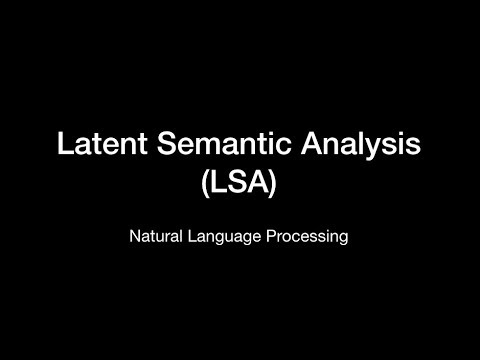

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('OvzJiur55vo', width=1024, height=576)

## 2.1 An example of Latent Semantic Analysis

Before we apply Latent Semantic Analysis in a pipeline, let's work through a simple example together in order to better understand how LSA works and develop an intuition along the way. 

First, if you haven't already, watch the short video provided above. We will be implementing the example from the video in our notebook. 

In [49]:
# Import

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer

svd = TruncatedSVD(n_components=2, # number of topics to generate (also the size of the new feature space)
                   algorithm='randomized',
                   n_iter=10)

# let's use the same data that was used in the video for consistancy 

        # topic 1 data 
data = ["pizza", 
        "pizza hamburger cookie",
        "hamburger", 
        # topic 2 data
        "ramen", 
        "sushi", 
        "ramen sushi"]

In [50]:
# CREATE Term-Frequency matrix 

###BEGIN SOLUTION
# use CountVectorizer to create a Term-Frequency matrix (a.k.a. Doc-Term Matrix )
tf_vectorizer = CountVectorizer()
tfm = tf_vectorizer.fit_transform(data)
tfm = pd.DataFrame(data=tfm.toarray(), columns=tf_vectorizer.get_feature_names())

# switch integer indicies with terms
tfm.index = data
tfm
###END SOLUTION

,cookie,hamburger,pizza,ramen,sushi
pizza,0,0,1,0,0
pizza hamburger cookie,1,1,1,0,0
hamburger,0,1,0,0,0
ramen,0,0,0,1,0
sushi,0,0,0,0,1
ramen sushi,0,0,0,1,1


In [51]:
# Use SVD to transform our Term-Frequency matrix into a Topic matrix with reduced dimensionality


###BEGIN SOLUTION
# Use SVD to transform our Term-Frequency matrix into a Topic matrix with reduced dimensionality
X_reduced = svd.fit_transform(tfm)

# this is the output of SVD
# same number of rows 
# number of features has been reduced to 2 
X_reduced.round(2)
###END SOLUTION

array([[ 0.63, -0.  ],
       [ 1.72, -0.  ],
       [ 0.63,  0.  ],
       [-0.  ,  0.71],
       [ 0.  ,  0.71],
       [ 0.  ,  1.41]])

In [52]:
# let's move X_reduced into a dataframe and rename the indices and columns for interpretability  

###BEGIN SOLUION
# let's move X_reduced into a dataframe and rename the indicies and columns for interpretability  
topic_cols = ["topic_1", "topic_2"]
dtm_reduced = pd.DataFrame(data=X_reduced.round(2), columns=topic_cols)
dtm_reduced.index = data
dtm_reduced
###END SOLUTION

,topic_1,topic_2
pizza,0.63,-0.00
pizza hamburger cookie,1.72,-0.00
hamburger,0.63,0.00
ramen,-0.00,0.71
sushi,0.00,0.71
ramen sushi,0.00,1.41


## 2.2 Build a Latent Semantic Analysis (LSA) pipeline 


Ok, now that we have gone through an example of applying LSA on a small dataset, let's apply it in a model building pipeline. <br>
We'll run the pipeline on the `20newsgroups` data 

In [53]:
# build a pipeline, incorporate SVD, and run a gridsearch 

###BEGIN SOLUTION
svd = TruncatedSVD(n_components=100, # number of topics to generate (also reduces the size of the feature space)
                   algorithm='randomized',
                   n_iter=10)

# instantiate a pipeline object
lsi = Pipeline([("vect", tfidf), # creating our term-doc matrix
                ("svd", svd)]) # apply svd to our term-doc matrix 

# instantiate a pipeline object
pipe = Pipeline([("lsi", lsi), # data transform
                 ("clf", rfc)]) # estimator 

# a nice default starter set for hyper-parameter values
# include more parameters and values to try to increase model performance 
params = { 
    'lsi__svd__n_components': [10, 100, 250],
    'lsi__vect__max_df':[.9,  1.0],
    'clf__n_estimators':[10, 100, 250], 
    'clf__max_depth':(15, 20)
}


gs = GridSearchCV(pipe,
                  param_grid=params, 
                  cv=3, 
                  n_jobs=-2, 
                  verbose=1 )



In [54]:
%%time
gs.fit(X_clean, Y)
###END SOLUTION

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-2)]: Done 108 out of 108 | elapsed:  6.3min finished


CPU times: user 7min 8s, sys: 2min 50s, total: 9min 59s
Wall time: 6min 21s


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('lsi',
                                        Pipeline(memory=None,
                                                 steps=[('vect',
                                                         TfidfVectorizer(analyzer='word',
                                                                         binary=False,
                                                                         decode_error='strict',
                                                                         dtype=<class 'numpy.float64'>,
                                                                         encoding='utf-8',
                                                                         input='content',
                                                                         lowercase=True,
                                                                         max_df=1.0,
             

In [55]:
gs.best_params_

{'clf__max_depth': 15,
 'clf__n_estimators': 100,
 'lsi__svd__n_components': 100,
 'lsi__vect__max_df': 1.0}

In [56]:
gs.cv_results_

{'mean_fit_time': array([0.6868813 , 0.62597863, 2.39705642, 2.46745849, 5.17486755,
        4.5437425 , 0.84492087, 0.85087093, 2.90328153, 2.92515111,
        5.8493189 , 5.88584717, 1.34780947, 1.31360149, 3.66109149,
        4.08142161, 7.53502369, 7.49947866, 0.66988659, 0.64604847,
        2.19943794, 2.12041004, 4.61449734, 4.71089323, 1.0038747 ,
        0.9732128 , 2.99840426, 3.06284118, 5.59618847, 6.00090718,
        1.29859193, 1.44993679, 3.74275589, 3.79474862, 7.41069738,
        7.10306946]),
 'mean_score_time': array([0.16307704, 0.14818017, 0.13912439, 0.13608797, 0.14760454,
        0.14207546, 0.13079659, 0.13901742, 0.16883564, 0.1516374 ,
        0.19070482, 0.17880932, 0.15345128, 0.15939784, 0.175946  ,
        0.18937373, 0.22648668, 0.21767465, 0.15640887, 0.15067689,
        0.13453563, 0.15152415, 0.13776588, 0.13718279, 0.1591514 ,
        0.14268907, 0.1514082 , 0.16369494, 0.17501839, 0.15902702,
        0.16048217, 0.1589272 , 0.17747823, 0.17154805, 0.

In [57]:
gs.best_score_

0.8794663128409258

In [58]:
dir(gs)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_is_fitted',
 '_estimator_type',
 '_format_results',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_pairwise',
 '_required_parameters',
 '_run_search',
 'best_estimator_',
 'best_index_',
 'best_params_',
 'best_score_',
 'classes_',
 'cv',
 'cv_results_',
 'decision_function',
 'error_score',
 'estimator',
 'fit',
 'get_params',
 'iid',
 'inverse_transform',
 'multimetric_',
 'n_jobs',
 'n_splits_',
 'param_grid',
 'pre_dispatch',
 'predict',
 'predict_log_proba',
 'predict_proba',
 'refit',
 'refit_time_',
 'return_train_score',
 'score

## Challenge

Continue to apply Latent Semantic Indexing (LSI) to various datasets. 

#3. Word Embeddings with Spacy (Learn)
In this section we'll complete our preparation for Lambda School's [Whisky Classification Kaggle Competition](https://www.kaggle.com/c/whiskey-201911/)
<a id="p3"></a>

## Follow Along
1. Join the [Whisky Classification Kaggle Competition](https://www.kaggle.com/c/whiskey-201911/)
2. Download the data to your local machine, then upload the files to your Colab notebook by first clicking the **folder icon** in the left sidebar, then clicking the **folder with the up arrow icon** that appears under "Files" in the left sidebar. The files should now be in the /content folder. To get the path to an object that appears in the left sidebar, hover over it, click the three vertical dots that appear on the right, then select "Copy path".

## 3.1 Get the data
Download the `.csv` files from the [Whisky Classification Kaggle Competition](https://www.kaggle.com/c/whiskey-201911/) to your local machine, <br>
then upload them to this Colab notebook.

In [61]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

##3.2 Build a classification model that is trained on the word vectors from spacy
Run the model on the Whisky data set and get a preliminary result

In [62]:
%%time
# build a model that is trained on word vectors 

###BEGIN SOLUTION
def get_word_vectors(docs):
    """
    This serves as both our tokenizer and vectorizer. 
    Returns a list of word vectors, i.e. our doc-term matrix
    """
    return [nlp(doc).vector for doc in docs]

# You may need to change the path
#train = pd.read_csv('./Kaggle Data/train.csv')
#test = pd.read_csv('./Kaggle Data/test.csv')

# create our doc-term matrices 

# raw text data for train and test sets
X_train_text = train["description"]
X_test_text = test["description"]

# transform raw data into doc-term matrices for train and test sets 
X_train = get_word_vectors(X_train_text)
X_test = get_word_vectors(X_test_text)

# save ratings to y vector
y_train = train["ratingCategory"]

# create RF model, use out-of-bag (oob) score
rfc = RandomForestClassifier(oob_score=True)

rfc.fit(X_train, y_train)
###END SOLUTION

CPU times: user 2min 42s, sys: 2.64 s, total: 2min 45s
Wall time: 3min 22s


In [ ]:
# train set accuracy
rfc.score(X_train, Y_train)

0.9997553217518963

In [63]:
# out-of-bag accuracy score, which can be thought of as a proxy for the test set score 
rfc.oob_score_

0.7183753364325911

In [64]:
y_train.unique()

array([1, 0, 2])

## Challenge  -- this afternoon's lab module assignment

1. Join Lambda School's [Whisky Classification Kaggle Competition](https://www.kaggle.com/c/whiskey-201911/)
2. Download the data
3. Train a model & try: 
    - Creating a Text Extraction & Classification Pipeline
    - Tune the pipeline with a `GridSearchCV` or `RandomizedSearchCV`
    - Add some Latent Semantic Indexing (lsi) into your pipeline. *Note:* You can grid search a nested pipeline, but you have to use double underscores ie `lsi__svd__n_components`
    - Try to extract word embeddings with Spacy and use those embeddings as your features for a classification model.
4. Make a submission to Kaggle 

Note: You can put together your project from code snippets from the current Colab notebook. <br>
Alternatively, you can adapt and refactor this [Colab notebook](https://drive.google.com/file/d/1ZY-P33tXD5y-VucOjg2TXO5OAQBWuTLf/view?usp=sharing) to work with the Kaggle data for your project.

# Review

To review this module: 
* Continue working on the Kaggle competition
* Find another text classification task to work on